<a href="https://colab.research.google.com/github/nguyenanhtienabcd/AIO2024_EXERCISE/blob/feature%2FMODULE9-WEEK1/m09w01_ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer with Rotation

## Data

In [ ]:
!gdown 1mU--DNhy8pWMTljj7jI3FvJwRYRHwAq5
!gdown 13XpLuVuxI6ekdEf5UElKH_IMWrK8wZU1

Downloading...
From: https://drive.google.com/uc?id=1mU--DNhy8pWMTljj7jI3FvJwRYRHwAq5
To: /content/content_img.jpg
100% 1.15M/1.15M [00:00<00:00, 11.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=13XpLuVuxI6ekdEf5UElKH_IMWrK8wZU1
To: /content/style_img2.jpg
100% 1.02M/1.02M [00:00<00:00, 10.1MB/s]


In [ ]:
# import thư viện
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# data và chuyển ảnh sang tensor
from PIL import Image
import torchvision.transforms as transforms

imsize = 256

img_transforms = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor(),
])

In [ ]:
# định nghĩa một hàm image_loader
def image_loader(image_name):
  image = Image.open(image_name) # đọc ảnh
  image = img_transforms(image).unsqueeze(0) # thêm chiều batch_size vào ảnh
  return image.to(device, torch.float)

In [ ]:
style_img = image_loader("style_img2.jpg")
content_img = image_loader("content_img.jpg")

In [ ]:
# định nghĩa một hàm hiển thị hình ảnh
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
  image = tensor.cpu().clone() # copy dữ liệu trên GPU sang CPU
  image = image.squeeze(0) # loại bỏ đi chiều batch_size
  image = unloader(image) # chuyển dữ liệu từ tensor sang ảnh
  plt.imshow(image) # hiển thị ảnh

  if title is not None:
    plt.title(title)
  plt.pause(0.001) # dùng để pause cho phép hiển thị trước khi tiếp tục đoạn code

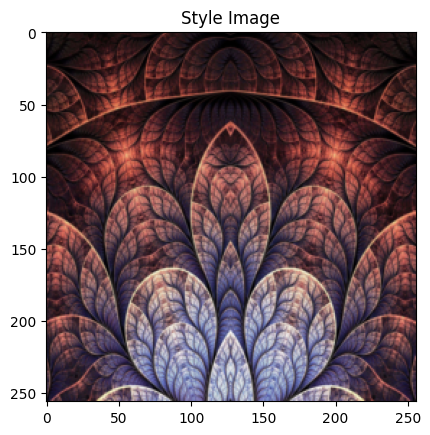

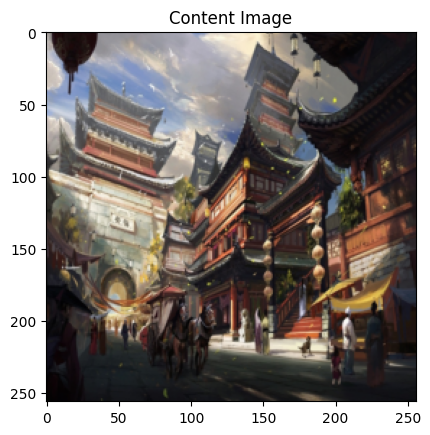

In [ ]:
# hiển thị hình ảnh
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Loss

In [ ]:
content_weight = 1
ContentLoss = nn.MSELoss()

In [ ]:
# Gram matrix
def gram_matrix(input):
  a, b, c, d = input.size()
  features = input.view(a*b, c*d)
  G = torch.mm(features, features.t())
  return G.div(a*b*c*d) # chuẩn hóa dữ liệu

style_weight = 1e6
StyleLoss = nn.MSELoss()

In [ ]:
# lấy model có sẵn thông số
from torchvision.models import vgg19, VGG19_Weights
VGG19_pretrained = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()
VGG19_pretrained.to(device) # chuyển model sang GPU

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 160MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
class Normalization(nn.Module):
  def __init__(self):
    super(Normalization, self).__init__()
    # Các giá trị mean và std này được tính từ toàn bộ dữ liệu ảnh trong tập ImageNet,
    # là một tập dữ liệu chuẩn rất lớn và phổ biến,
    # thường được dùng để huấn luyện các pretrained model như VGG, ResNet, DenseNet, EfficientNet, v.v.
    self.mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406]).to(device)).view(-1, 1, 1)
    self.std = torch.tensor(torch.tensor([0.229, 0.224, 0.225]).to(device)).view(-1, 1, 1)

  def forward(self, img):
    return (img - self.mean) / self.std

In [ ]:
normalization = Normalization().to(device)

<ipython-input-15-d2b9bf48503f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406]).to(device)).view(-1, 1, 1)
<ipython-input-15-d2b9bf48503f>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(torch.tensor([0.229, 0.224, 0.225]).to(device)).view(-1, 1, 1)


In [ ]:
def get_features(pretrained_model, image):
  layers = {
      '0': 'conv_1',
      '5': 'conv_2',
      '16': 'conv_3',
      '19': 'conv_4',
      '21': 'conv_5',
  }
  features = {}
  x = image
  x = normalization(x)
  for name, layer in pretrained_model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x
  return features

In [ ]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2',
                'conv_3', 'conv_4',
                'conv_5']

In [ ]:
def rot_style_features(style_features, style_layers):
    final_rot_style_features = {}
    for layer in style_layers:
        sf = style_features[layer].clone()
        rot_90 = torch.rot90(sf, k=1, dims=(2, 3))
        rot_180 = torch.rot90(rot_90, k=1, dims=(2, 3))
        final_rot = sf + (rot_90 - rot_180)
        final_rot_style_features[layer] = final_rot
    return final_rot_style_features

In [ ]:
content_features = get_features(VGG19_pretrained, content_img)
style_features1 = get_features(VGG19_pretrained, style_img)
final_rot_style_features = rot_style_features(style_features1, style_layers)

## Training dữ liệu

In [ ]:
import torch.optim as optim

target_img1 = content_img.clone().requires_grad_(True).to(device)
target_img2 = content_img.clone().requires_grad_(True).to(device)
optimizer1 = optim.Adam([target_img1], lr=0.02)
optimizer2 = optim.Adam([target_img2], lr=0.02)

In [ ]:
def style_transfer_(model, optimizer, target_img,
                   content_features, style_features,
                   style_layers, content_weight,
                   style_weight):
  optimizer.zero_grad()
  with torch.no_grad():
    target_img.clamp_(0,1) # vì nội dụng của ảnh trong quá trình training sẽ bị thay đổi có thể lớn hơn 1 hoặc bé hơn 0
  target_features = get_features(model, target_img)

  content_loss = ContentLoss(content_features[content_layers[0]],
                             target_features[content_layers[0]])

  style_loss = 0
  for layer in style_layers:
    target_gram = gram_matrix(target_features[layer])
    style_gram = gram_matrix(style_features[layer])
    style_loss += StyleLoss(style_gram, target_gram)

  total_loss = content_weight*content_loss + style_weight*style_loss
  total_loss.backward(retain_graph=True)
  optimizer.step()
  return total_loss, content_loss, style_loss


In [ ]:
STEPS = 500

for step in range(STEPS):

    total_loss1, content_loss1, style_loss1 = style_transfer_(VGG19_pretrained, optimizer1, target_img1,
                                                           content_features, style_features1,
                                                           style_layers, content_weight, style_weight)

    total_loss2, content_loss2, style_loss2 = style_transfer_(VGG19_pretrained, optimizer2, target_img2,
                                                           content_features, final_rot_style_features,
                                                           style_layers, content_weight, style_weight)

    if step % 100 == 99:
        print(f"Epoch [{step+1}/{STEPS}] Total loss1: {total_loss1.item():.6f} - \
                Content loss1: {content_loss1.item():.6f} - Style loss1: {style_loss1.item():.6f}")
        print(f"Epoch [{step+1}/{STEPS}] Total loss2: {total_loss2.item():.6f} - \
                Content loss1: {content_loss2.item():.6f} - Style loss2: {style_loss2.item():.6f}")

    with torch.no_grad():
        target_img1.clamp_(0, 1)
        target_img2.clamp_(0, 1)

Epoch [100/500] Total loss1: 34.889046 -                 Content loss1: 24.237980 - Style loss1: 0.000011
Epoch [100/500] Total loss2: 466.795837 -                 Content loss1: 48.850273 - Style loss2: 0.000418
Epoch [200/500] Total loss1: 31.787430 -                 Content loss1: 22.739527 - Style loss1: 0.000009
Epoch [200/500] Total loss2: 438.179321 -                 Content loss1: 50.369579 - Style loss2: 0.000388
Epoch [300/500] Total loss1: 30.971245 -                 Content loss1: 22.480494 - Style loss1: 0.000008
Epoch [300/500] Total loss2: 425.234314 -                 Content loss1: 50.469391 - Style loss2: 0.000375
Epoch [400/500] Total loss1: 29.998018 -                 Content loss1: 22.027243 - Style loss1: 0.000008
Epoch [400/500] Total loss2: 419.568115 -                 Content loss1: 50.021599 - Style loss2: 0.000370
Epoch [500/500] Total loss1: 29.595625 -                 Content loss1: 21.709162 - Style loss1: 0.000008
Epoch [500/500] Total loss2: 415.419830 - 

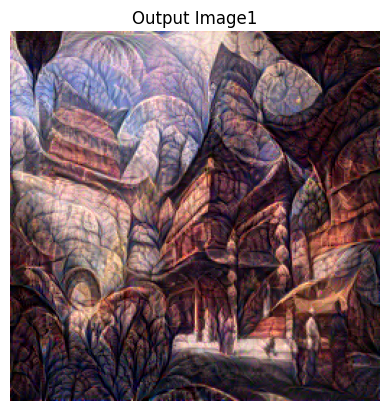

In [ ]:
plt.figure()
plt.axis('off')

imshow(target_img1.detach(), title='Output Image1')
plt.show()


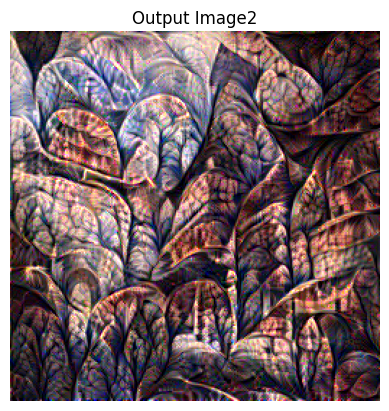

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure()
plt.axis('off')

imshow(target_img2.detach(), title='Output Image2')
plt.show()
